<a href="https://colab.research.google.com/github/zxyao5148/STAT3612_2023_1A_GroupProject/blob/main/RNN_Transformer/transformer_median.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeseries classification with a Transformer model

[Code source](https://keras.io/examples/timeseries/timeseries_classification_transformer/)<br>
**Description:** This notebook demonstrates how to do timeseries classification using a Transformer model.

## Introduction

This is the Transformer architecture from
[Attention Is All You Need](https://arxiv.org/abs/1706.03762),
applied to timeseries instead of natural language.

This example requires TensorFlow 2.4 or higher.

## Load the dataset

We are going to use the same dataset and preprocessing as the
[TimeSeries Classification from Scratch](https://keras.io/examples/timeseries/timeseries_classification_from_scratch)
example.

In [1]:
import pandas as pd
import requests
from io import StringIO
import numpy as np
from sklearn.model_selection import train_test_split

# Raw URLs for the CSV files
train_url = "https://raw.githubusercontent.com/zxyao5148/STAT3612_2023_1A_GroupProject/main/data_processing/train/train_valid_median.csv"
test_url = "https://raw.githubusercontent.com/zxyao5148/STAT3612_2023_1A_GroupProject/main/data_processing/test/test_median.csv"

# Download the CSV files
train_csv = requests.get(train_url).text
test_csv = requests.get(test_url).text

# Read the CSV files into pandas DataFrames
train = pd.read_csv(StringIO(train_csv))
test = pd.read_csv(StringIO(test_csv))

train['deathtime'] = np.where(train['deathtime'].notnull(), 1, 0)
test['deathtime'] = np.where(test['deathtime'].notnull(), 1, 0)

# Split the data into features (X) and target variable (y)
x_train = train[['deathtime']].join(train.iloc[:, 9:])
y_train = train.iloc[:, 8]

x_test = test[['deathtime']].join(test.iloc[:,8:])

In [2]:
x_train = x_train.values.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.values.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

# Reset the index of the y_train DataFrame
y_train = y_train.reset_index(drop=True)

# Shuffle the indices
idx = np.random.permutation(len(x_train))

# Reassign the values using the shuffled indices
x_train = x_train[idx]
y_train = y_train.iloc[idx]

In [3]:
train

,id,subject_id,hadm_id,admittime,dischtime,deathtime,StudyDate,StudyTime,readmitted_within_30days,stay_len,...,CARDIAC DRUGS,PRE-NATAL VITAMINS,ANESTHETICS,ANTIBIOTICS,ANTIHYPERGLYCEMICS,SEDATIVE/HYPNOTICS,ANTIDOTES,AUTONOMIC DRUGS,VITAMINS,BIOLOGICALS
0,17195991_23542772,17195991,23542772,2110-01-11 22:47:00,2110-01-18 10:25:00,0,2110-01-16,90654.546,0,-0.426682,...,-0.377683,-0.015166,-0.464590,-0.455359,-0.324178,-0.428196,-0.047867,2.207636,-0.380706,-0.304657
1,13721591_20342223,13721591,20342223,2110-02-09 18:13:00,2110-02-22 20:51:00,0,2110-02-19,41948.468,0,-0.025023,...,-0.377683,-0.015166,0.215206,-0.131342,-0.237635,-0.428196,-0.047867,-0.305346,-0.380706,-0.304657
2,10582595_20690213,10582595,20690213,2110-02-09 20:41:00,2110-02-17 15:40:00,0,2110-02-16,50133.578,0,-0.369302,...,0.535307,-0.015166,3.614190,0.192675,-0.324178,-0.065231,-0.047867,-0.305346,-0.380706,-0.304657
3,14385035_20480421,14385035,20480421,2110-02-23 14:28:00,2110-03-11 17:29:00,0,2110-02-28,214324.437,0,0.147116,...,0.991801,-0.015166,-0.464590,0.840709,0.021994,-0.428196,-0.047867,-0.305346,-0.380706,1.551782
4,19170541_22178312,19170541,22178312,2110-02-28 21:48:00,2110-03-12 17:47:00,0,2110-03-11,81842.812,0,-0.139783,...,-0.377683,-0.015166,0.215206,-0.293350,-0.324178,-0.428196,-0.047867,-0.305346,-0.380706,-0.304657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11591,19508874_28498140,19508874,28498140,2207-04-29 16:20:00,2207-05-06 16:08:00,0,2207-05-03,35201.421,0,-0.426682,...,-0.377683,-0.015166,-0.464590,-0.131342,0.195080,-0.428196,-0.047867,-0.305346,0.718017,1.551782
11592,13364829_26673737,13364829,26673737,2207-12-15 20:42:00,2208-01-13 19:15:00,0,2208-01-08,161351.843,1,0.835675,...,-0.377683,-0.015166,-0.464590,0.354683,0.108537,2.838489,-0.047867,-0.305346,4.014184,-0.304657
11593,14434519_22141373,14434519,22141373,2207-12-25 15:35:00,2207-12-31 16:44:00,0,2207-12-30,80953.312,0,-0.426682,...,-0.377683,-0.015166,-0.464590,-0.779376,-0.324178,-0.428196,-0.047867,-0.305346,-0.380706,-0.304657
11594,15888895_21231897,15888895,21231897,2208-01-13 06:54:00,2208-01-29 16:05:00,0,2208-01-27,83559.671,0,0.147116,...,5.100253,-0.015166,0.895003,-0.617367,-0.324178,-0.428196,-0.047867,-0.305346,-0.380706,-0.304657


## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

You can replace your classification RNN layers with this one: the
inputs are fully compatible!

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

In [5]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.

In [6]:

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


## Train

In [7]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history=model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 1)]             0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 150, 1)               2         ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 150, 1)               7169      ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                              

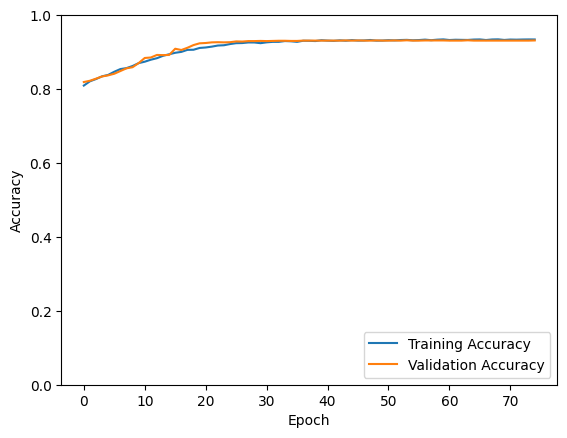

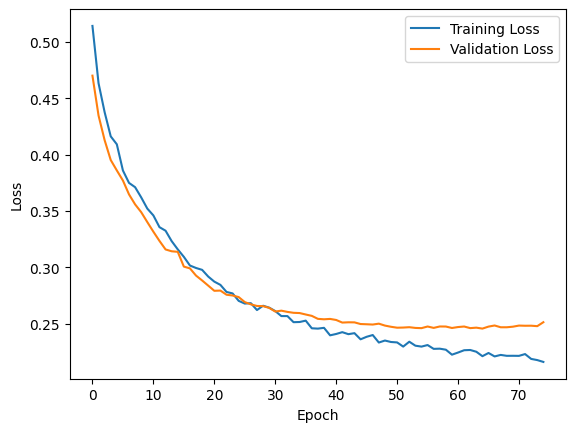

In [8]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy over epochs
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [9]:
from sklearn.metrics import roc_auc_score

y_train_pred = model.predict(x_train)
# Convert probabilities to binary predictions
y_train_pred_binary = np.argmax(y_train_pred, axis=1) # Choose the class with the highest probability


363/363 [==============================] - 6s 16ms/step


In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
accuracy_train = accuracy_score(y_train, y_train_pred_binary)
auc_train = roc_auc_score(y_train, y_train_pred[:, 1])

print(f'Accuracy (train): {accuracy_train:.4f}')
print(f'AUC (train): {auc_train:.4f}')


Accuracy (train): 0.9338
AUC (train): 0.8949


In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_train, y_train_pred_binary)
recall = recall_score(y_train, y_train_pred_binary)
f1 = f1_score(y_train, y_train_pred_binary)

# Print with 4 digits limit
print("For training set:")
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4),"\n")

For training set:
Precision: 0.9976
Recall: 0.6235
F1 Score: 0.7674 



## Export prediction

In [12]:
y_test_pred = model.predict(x_test)
y_test_pred_binary = np.argmax(y_test_pred, axis=1)

92/92 [==============================] - 2s 17ms/step


In [13]:
# Assuming y_test_pred_binary is a numpy array
predictions_df = pd.DataFrame(y_test_pred_binary, columns=['readmitted_within_30days'])
merged_df = test[['id']].merge(predictions_df, left_index=True, right_index=True)
merged_df.to_csv('predictions.csv', index=False)

from google.colab import files
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>